# Clusterización

 Utilizando el set de datos que hayas utilizado en las prácticas anteriores, aplica el modelo K-Means para realizar una agrupación de la data, posteriormente realiza análisis sobre los resultados y presenta los mismos en un reporte que contenga: Objetivo, técnica de aprendizaje, código, gráficas e interpretación de resultados. 

- Elige Set de Datos (Opiniones)

In [97]:
import pandas as pd
# Cargar el archivo Excel
file_path = 'corpus/Rest_Mex_2022_Sentiment_Analysis_Track_Train.xlsx'
df = pd.read_excel(file_path)
df.head()

,Title,Opinion,Polarity,Attraction
0,Pésimo lugar,"Piensen dos veces antes de ir a este hotel, te...",1,Hotel
1,No vayas a lugar de Eddie,Cuatro de nosotros fuimos recientemente a Eddi...,1,Restaurant
2,Mala relación calidad-precio,seguiré corta y simple: limpieza\n- bad. Tengo...,1,Hotel
3,Minusválido? ¡No te alojes aquí!,Al reservar un hotel con multipropiedad Mayan ...,1,Hotel
4,Es una porqueria no pierdan su tiempo,"No pierdan su tiempo ni dinero, venimos porque...",1,Hotel


**Preprocesa el set de datos: Aplicación de técnicas de Normalización (minúsculas, tokenización, eliminación de stopwords)**
- Funcion para preprocesamiento del texto

In [98]:
# Bibliotecas para procesamiento de texto
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# Eliminamos valores nulos
df = df.dropna()
# Lematizador
lemmatizer = WordNetLemmatizer()
# Stopwords en español
stop_words = set(stopwords.words('spanish'))
# Creamos lista de tags a utilizar
tags = ['ADJ', 'NOUN', 'VERB']
# Cargar el modelo de spaCy para español
nlp = spacy.load("es_core_news_sm")

def normalize_text(text):
    # Tokenizar el texto
    tokens = word_tokenize(text)
    # Convertir a minúsculas
    tokens_lower = [word.lower() for word in tokens]
    # Eliminar puntuación
    tokens_no_punct = [word for word in tokens_lower if word.isalnum()]
    # Eliminar stopwords
    tokens_no_stopwords = [word for word in tokens_no_punct if word not in stop_words]
    # Unir tokens
    tokens = " ".join(tokens_no_stopwords)
    # Procesar texto con spaCy
    doc = nlp(tokens)
    # Discriminar por tags
    normalized_text = [word.lemma_ for word in doc if word.pos_ in tags]
    # normalized_text = [word.lemma_ for word in doc]
    # Unir en una sola cadena
    normalized_text = " ".join(normalized_text)

    return normalized_text

#sample_sentence = "¡Hola, Juan! ¿Cómo estás? Él está viajando en un avión a París. ¡Qué emocionante! #vacaciones"
#normalize_text(sample_sentence)


- Preprocesamiento del texto en paralelo

In [99]:
from concurrent.futures import ThreadPoolExecutor

def parallel_processing_threads(data, func):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(func, data))
    return results

# Normaliza el dataframe en paralelo
df['Opinion'] = parallel_processing_threads(df['Opinion'], normalize_text)

# Mostrar el dataframe
df.head()

,Title,Opinion,Polarity,Attraction
0,Pésimo lugar,pensar vez ir hotel molestar año traer inflabl...,1,Hotel
1,No vayas a lugar de Eddie,placir servicio terrible pesar hecho venir ven...,1,Restaurant
2,Mala relación calidad-precio,seguir corta simple limpieza bad insistir limp...,1,Hotel
3,Minusválido? ¡No te alojes aquí!,reservar hotel grupo decir necesitar habitació...,1,Hotel
4,Es una porqueria no pierdan su tiempo,perder tiempo dinero venir boda complejo grand...,1,Hotel


**Vectoriza el dataset con Red Neuronal Doc2Vec**

In [100]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Preparar los datos
tagged_data = [TaggedDocument(words=opinion.split(), tags=[str(i)]) for i, opinion in enumerate(df['Opinion'])]

# Construir y entrenar el modelo
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Guardar el modelo para uso futuro
model.save("doc2vec_model_cluster")

**Cargar el modelo**

In [131]:
from gensim.models.doc2vec import Doc2Vec
import numpy as np

# Cargar el modelo
model = Doc2Vec.load("doc2vec_model_cluster")

# Preparar los datos
vector_op = np.array([model.infer_vector(opinion.split()) for opinion in df['Opinion']])

# Dimensiones del vector
vector_op.shape

(30208, 20)

**Crear nuevo Dataframe con el vector**

In [252]:
df_vector = pd.DataFrame(vector_op)

# Eliminar valores nulos
df_vector = df_vector.dropna()

# Nombrar columnas
df_vector.columns = ['V' + str(i) for i in range(20)]

# Mostrar el dataframe
df_vector.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19
0,3.631859,-0.883589,-3.403594,-0.472871,0.173111,0.187802,-0.075476,2.291797,-1.190175,0.632239,1.690607,0.721601,-0.637089,-0.283843,0.821772,1.243349,0.485215,1.648643,-1.051473,0.490309
1,2.125585,-3.808686,-2.165548,-0.047614,1.935529,-0.839085,1.410575,-0.714253,-3.014290,-1.987260,0.931677,1.042906,-1.450233,-1.591021,1.171507,1.717165,0.914884,-2.057830,-1.196334,0.080173
2,0.450851,-0.573771,-0.750699,-1.882346,-0.414354,-0.707304,2.759517,1.764088,0.104661,-1.926892,-1.429589,0.017823,0.362121,0.359722,0.086770,1.329939,0.687856,-2.143264,-1.666013,-2.185796
3,-0.057318,-2.892295,-3.184761,-1.678952,-1.804444,0.778306,0.851503,2.722060,-2.989532,0.767395,-0.749288,3.192304,-1.430115,0.636688,-1.981624,0.283117,-0.564727,0.476830,0.682896,-3.440943
4,3.774222,-0.050739,-1.149634,-2.380746,-0.669561,0.617497,-0.006348,0.600250,-1.443172,-0.927912,1.998112,-0.957790,-2.198265,0.830351,2.732185,0.195609,0.099196,1.571231,-0.026976,-1.445920


**Determina el número recomendado de clústers**

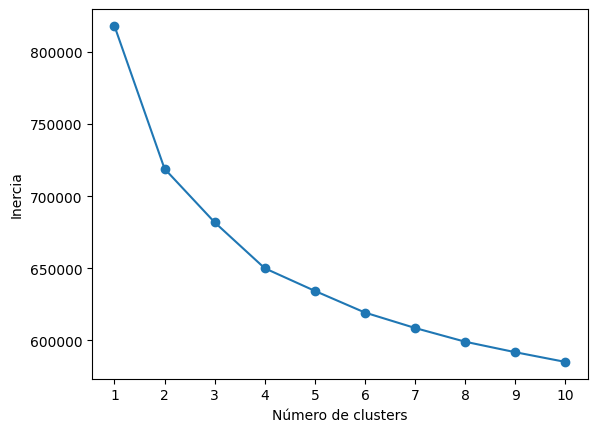

In [253]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Lista para almacenar los valores de la inercia
inertia = []

# Lista para almacenar el número de clusters
k = []

# Iterar de 1 a 10 clusters

for i in range(1, 11):
    # Crear el modelo
    model = KMeans(n_clusters=i, random_state=42, n_init=10)
    # Entrenar el modelo
    model.fit(df_vector)
    # Almacenar el valor de la inercia
    inertia.append(model.inertia_)
    # Almacenar el número de clusters
    k.append(i)

# Graficar el método del codo
plt.plot(k, inertia, '-o')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.xticks(k)
plt.show()


**Entrenar Modelo K-means**

In [254]:
# Prepapar los datos
X = df_vector

# Crear el modelo
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Entrenar el modelo
kmeans.fit(X)

KMeans(n_clusters=3, n_init=10, random_state=42)

**Evaluamos el modelo con metricas de Silueta y Calinski harabasz**

In [255]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

# Almacenar las etiquetas
ymeans = kmeans.labels_

print("El índice de silueta es: ", silhouette_score(X, ymeans))
print("La puntuación de Calinski-Harabasz es: ", calinski_harabasz_score(X, ymeans))

El índice de silueta es:  0.088405296
La puntuación de Calinski-Harabasz es:  3020.084198480165


**Utiliza un tensor para reducir la dimensionalidad de los vectores**

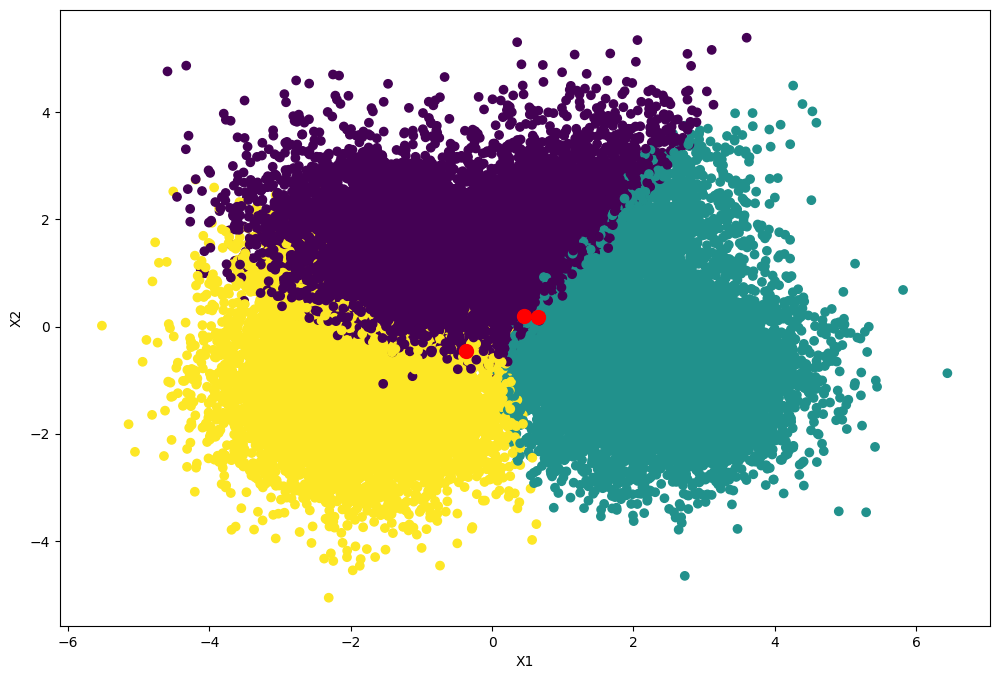

In [256]:
# reducir la dimensionalidad a 2 dimensiones
from sklearn.decomposition import PCA

# Crear el modelo
pca = PCA(n_components=2)

# Entrenar el modelo
pca.fit(X)

# Transformar los datos
X_pca = pca.transform(X)

# Graficar los clusters con centroides
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=100)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### Optimizacion de parametros para mejorar resultados

**Aplicamos Standar scaler a los datos**

In [257]:
# Aplicamos standard scaler
from sklearn.preprocessing import StandardScaler

# Preparar los datos
X = df_vector

# Crear el modelo
scaler = StandardScaler()

# Entrenar el modelo
scaler.fit(X)

# Transformar los datos
X_scaled = scaler.transform(X)

**Seleccion de caracteristicas con random forest**

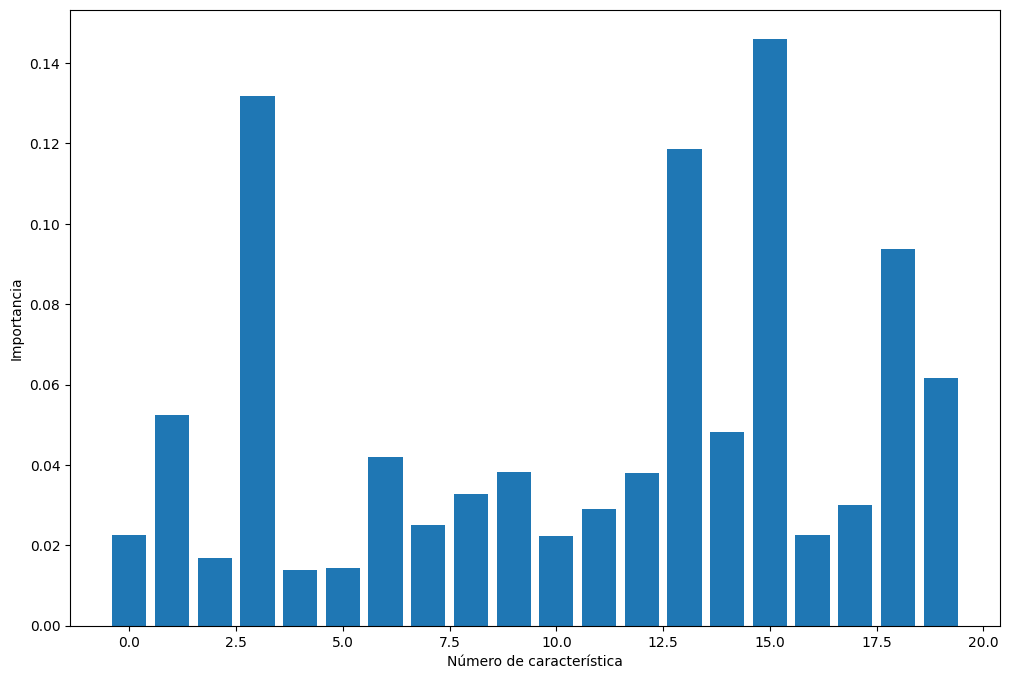

In [258]:
# Seleccion de características con random forest
from sklearn.ensemble import RandomForestClassifier

# Preparar los datos
y = df['Attraction'].copy()

# Crear el modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf.fit(X_scaled, y)
# Extraer las importancias de las características
importances = rf.feature_importances_

# Graficar las importancias de las características
plt.figure(figsize=(12, 8))
plt.bar(range(len(importances)), importances)
plt.xlabel('Número de característica')
plt.ylabel('Importancia')
plt.show()

**Seleccionamos las 15 mejores caracteristicas**

In [259]:
df_vector_important_features = df_vector.iloc[:, importances.argsort()[::-1][:15]]

# Mostrar el dataframe
df_vector_important_features.head()

,V15,V3,V13,V18,V19,V1,V14,V6,V9,V12,V8,V17,V11,V7,V16
0,1.243349,-0.472871,-0.283843,-1.051473,0.490309,-0.883589,0.821772,-0.075476,0.632239,-0.637089,-1.190175,1.648643,0.721601,2.291797,0.485215
1,1.717165,-0.047614,-1.591021,-1.196334,0.080173,-3.808686,1.171507,1.410575,-1.987260,-1.450233,-3.014290,-2.057830,1.042906,-0.714253,0.914884
2,1.329939,-1.882346,0.359722,-1.666013,-2.185796,-0.573771,0.086770,2.759517,-1.926892,0.362121,0.104661,-2.143264,0.017823,1.764088,0.687856
3,0.283117,-1.678952,0.636688,0.682896,-3.440943,-2.892295,-1.981624,0.851503,0.767395,-1.430115,-2.989532,0.476830,3.192304,2.722060,-0.564727
4,0.195609,-2.380746,0.830351,-0.026976,-1.445920,-0.050739,2.732185,-0.006348,-0.927912,-2.198265,-1.443172,1.571231,-0.957790,0.600250,0.099196


**Entrenar el modelo con esta configuracion de caracteristicas**

In [260]:
# Prepapar los datos
X_best = df_vector_important_features

# Crear el modelo
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Entrenar el modelo
kmeans.fit(X_best)

KMeans(n_clusters=3, n_init=10, random_state=42)

**Evaluar resultados**

In [261]:
ymeans_best = kmeans.labels_

print("El índice de silueta es: ", silhouette_score(X_best, ymeans_best))
print("La puntuación de Calinski-Harabasz es: ", calinski_harabasz_score(X_best, ymeans_best))

El índice de silueta es:  0.11122189
La puntuación de Calinski-Harabasz es:  3885.6378731763753
